# Non-Rigid Registration: Demons

This notebook illustrates the use of the Demons based non-rigid registration set of algorithms in SimpleITK. These include both the DemonsMetric which is part of the registration framework and Demons registration filters which are not.

The data we work with is a 4D (3D+time) thoracic-abdominal CT, the Point-validated Pixel-based Breathing Thorax Model (POPI) model. This data consists of a set of temporal CT volumes, a set of masks segmenting each of the CTs to air/body/lung, and a set of corresponding points across the CT volumes. 

The POPI model is provided by the Léon Bérard Cancer Center & CREATIS Laboratory, Lyon, France. The relevant publication is:

J. Vandemeulebroucke, D. Sarrut, P. Clarysse, "The POPI-model, a point-validated pixel-based breathing thorax model",
Proc. XVth International Conference on the Use of Computers in Radiation Therapy (ICCR), Toronto, Canada, 2007.

The POPI data, and additional 4D CT data sets with reference points are available from the CREATIS Laboratory <a href="http://www.creatis.insa-lyon.fr/rio/popi-model?action=show&redirect=popi">here</a>. 

In [1]:
import SimpleITK as sitk
import numpy as np

# If the environment variable SIMPLE_ITK_MEMORY_CONSTRAINED_ENVIRONMENT is set, this will override the ReadImage
# function so that it also resamples the image to a smaller size (testing environment is memory constrained).
%run setup_for_testing

import registration_utilities as ru
import registration_callbacks as rc

%matplotlib inline
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed

# utility method that either downloads data from the Girder repository or
# if already downloaded returns the file name for reading from disk (cached data)
%run update_path_to_download_script
from downloaddata import fetch_data as fdata

## Utilities

Load utilities that are specific to the POPI data, functions for loading ground truth data, display and the labels for masks.

In [2]:
%run popi_utilities_setup.py

## Loading Data

Load all of the images, masks and point data into corresponding lists. If the data is not available locally it will be downloaded from the original remote repository. 

Take a look at the images. According to the documentation on the POPI site, volume number one corresponds to end inspiration (maximal air volume).

In [3]:
images = []
masks = []
points = []
for i in range(0, 10):
    image_file_name = f"POPI/meta/{i}0-P.mhd"
    mask_file_name = f"POPI/masks/{i}0-air-body-lungs.mhd"
    points_file_name = f"POPI/landmarks/{i}0-Landmarks.pts"
    images.append(
        sitk.ReadImage(fdata(image_file_name), sitk.sitkFloat32)
    )  # read and cast to format required for registration
    masks.append(sitk.ReadImage(fdata(mask_file_name)))
    points.append(read_POPI_points(fdata(points_file_name)))

interact(
    display_coronal_with_overlay,
    temporal_slice=(0, len(images) - 1),
    coronal_slice=(0, images[0].GetSize()[1] - 1),
    images=fixed(images),
    masks=fixed(masks),
    label=fixed(lung_label),
    window_min=fixed(-1024),
    window_max=fixed(976),
);

Fetching POPI/meta/00-P.mhd
Fetching POPI/masks/00-air-body-lungs.mhd
Fetching POPI/landmarks/00-Landmarks.pts
Fetching POPI/meta/10-P.mhd
Fetching POPI/masks/10-air-body-lungs.mhd
Fetching POPI/landmarks/10-Landmarks.pts
Fetching POPI/meta/20-P.mhd
Fetching POPI/masks/20-air-body-lungs.mhd
Fetching POPI/landmarks/20-Landmarks.pts
Fetching POPI/meta/30-P.mhd
Fetching POPI/masks/30-air-body-lungs.mhd
Fetching POPI/landmarks/30-Landmarks.pts
Fetching POPI/meta/40-P.mhd
Fetching POPI/masks/40-air-body-lungs.mhd
Fetching POPI/landmarks/40-Landmarks.pts
Fetching POPI/meta/50-P.mhd
Fetching POPI/masks/50-air-body-lungs.mhd
Fetching POPI/landmarks/50-Landmarks.pts
Fetching POPI/meta/60-P.mhd
Fetching POPI/masks/60-air-body-lungs.mhd
Fetching POPI/landmarks/60-Landmarks.pts
Fetching POPI/meta/70-P.mhd
Fetching POPI/masks/70-air-body-lungs.mhd
Fetching POPI/landmarks/70-Landmarks.pts
Fetching POPI/meta/80-P.mhd
Fetching POPI/masks/80-air-body-lungs.mhd
Fetching POPI/landmarks/80-Landmarks.pts
F

interactive(children=(IntSlider(value=4, description='temporal_slice', max=9), IntSlider(value=179, descriptio…

## Demons Registration

This function will align the fixed and moving images using the Demons registration method. If given a mask, the similarity metric will be evaluated using points sampled inside the mask. If given fixed and moving points the similarity metric value and the target registration errors will be displayed during registration. 

As this notebook performs intra-modal registration, we can readily use the Demons family of algorithms.

We start by using the registration framework with SetMetricAsDemons. We use a multiscale approach which is readily available in the framework. We then illustrate how to use the Demons registration filters that are not part of the registration framework.

In [4]:
def demons_registration(
    fixed_image, moving_image, fixed_points=None, moving_points=None
):

    registration_method = sitk.ImageRegistrationMethod()

    # Create initial identity transformation.
    transform_to_displacment_field_filter = sitk.TransformToDisplacementFieldFilter()
    transform_to_displacment_field_filter.SetReferenceImage(fixed_image)
    # The image returned from the initial_transform_filter is transferred to the transform and cleared out.
    initial_transform = sitk.DisplacementFieldTransform(
        transform_to_displacment_field_filter.Execute(sitk.Transform())
    )

    # Regularization (update field - viscous, total field - elastic).
    initial_transform.SetSmoothingGaussianOnUpdate(
        varianceForUpdateField=0.0, varianceForTotalField=2.0
    )

    registration_method.SetInitialTransform(initial_transform)

    registration_method.SetMetricAsDemons(
        10
    )  # intensities are equal if the difference is less than 10HU

    # Multi-resolution framework.
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[8, 4, 0])

    registration_method.SetInterpolator(sitk.sitkLinear)
    # If you have time, run this code as is, otherwise switch to the gradient descent optimizer
    # registration_method.SetOptimizerAsConjugateGradientLineSearch(learningRate=1.0, numberOfIterations=20, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
    registration_method.SetOptimizerAsGradientDescent(
        learningRate=1.0,
        numberOfIterations=20,
        convergenceMinimumValue=1e-6,
        convergenceWindowSize=10,
    )
    registration_method.SetOptimizerScalesFromPhysicalShift()

    # If corresponding points in the fixed and moving image are given then we display the similarity metric
    # and the TRE during the registration.
    if fixed_points and moving_points:
        registration_method.AddCommand(
            sitk.sitkStartEvent, rc.metric_and_reference_start_plot
        )
        registration_method.AddCommand(
            sitk.sitkEndEvent, rc.metric_and_reference_end_plot
        )
        registration_method.AddCommand(
            sitk.sitkIterationEvent,
            lambda: rc.metric_and_reference_plot_values(
                registration_method, fixed_points, moving_points
            ),
        )

    return registration_method.Execute(fixed_image, moving_image)

Running the Demons registration with the conjugate gradient optimizer on this data <font color="red">takes a long time</font> which is why the code above uses gradient descent. If you are more interested in accuracy and have the time then switch to the conjugate gradient optimizer.

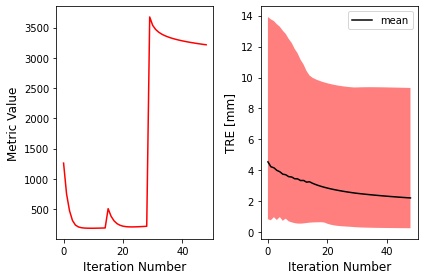

Initial alignment errors in millimeters, mean(std): 5.07(2.67), max: 14.02
Final alignment errors in millimeters, mean(std): 2.23(1.66), max: 9.33


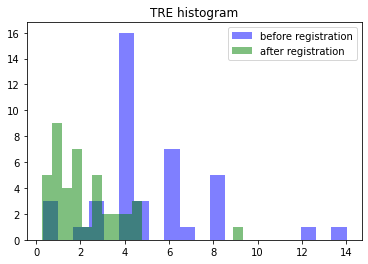

In [5]:
#%%timeit -r1 -n1
# Uncomment the line above if you want to time the running of this cell.

# Select the fixed and moving images, valid entries are in [0,9]
fixed_image_index = 0
moving_image_index = 7


tx = demons_registration(
    fixed_image=images[fixed_image_index],
    moving_image=images[moving_image_index],
    fixed_points=points[fixed_image_index],
    moving_points=points[moving_image_index],
)
(
    initial_errors_mean,
    initial_errors_std,
    _,
    initial_errors_max,
    initial_errors,
) = ru.registration_errors(
    sitk.Euler3DTransform(), points[fixed_image_index], points[moving_image_index]
)
(
    final_errors_mean,
    final_errors_std,
    _,
    final_errors_max,
    final_errors,
) = ru.registration_errors(tx, points[fixed_image_index], points[moving_image_index])

plt.hist(initial_errors, bins=20, alpha=0.5, label="before registration", color="blue")
plt.hist(final_errors, bins=20, alpha=0.5, label="after registration", color="green")
plt.legend()
plt.title("TRE histogram")
print(
    f"Initial alignment errors in millimeters, mean(std): {initial_errors_mean:.2f}({initial_errors_std:.2f}), max: {initial_errors_max:.2f}"
)
print(
    f"Final alignment errors in millimeters, mean(std): {final_errors_mean:.2f}({final_errors_std:.2f}), max: {final_errors_max:.2f}"
)

SimpleITK also includes a set of Demons filters which are independent of the ImageRegistrationMethod. These include: 
1. DemonsRegistrationFilter
2. DiffeomorphicDemonsRegistrationFilter
3. FastSymmetricForcesDemonsRegistrationFilter
4. SymmetricForcesDemonsRegistrationFilter

As these filters are independent of the ImageRegistrationMethod we do not have access to the multiscale framework. Luckily it is easy to implement our own multiscale framework in SimpleITK, which is what we do in the next cell.

In [6]:
def smooth_and_resample(image, shrink_factors, smoothing_sigmas):
    """
    Args:
        image: The image we want to resample.
        shrink_factor(s): Number(s) greater than one, such that the new image's size is original_size/shrink_factor.
        smoothing_sigma(s): Sigma(s) for Gaussian smoothing, this is in physical units, not pixels.
    Return:
        Image which is a result of smoothing the input and then resampling it using the given sigma(s) and shrink factor(s).
    """
    if np.isscalar(shrink_factors):
        shrink_factors = [shrink_factors] * image.GetDimension()
    if np.isscalar(smoothing_sigmas):
        smoothing_sigmas = [smoothing_sigmas] * image.GetDimension()

    smoothed_image = sitk.SmoothingRecursiveGaussian(image, smoothing_sigmas)

    original_spacing = image.GetSpacing()
    original_size = image.GetSize()
    new_size = [
        int(sz / float(sf) + 0.5) for sf, sz in zip(shrink_factors, original_size)
    ]
    new_spacing = [
        ((original_sz - 1) * original_spc) / (new_sz - 1)
        for original_sz, original_spc, new_sz in zip(
            original_size, original_spacing, new_size
        )
    ]
    return sitk.Resample(
        smoothed_image,
        new_size,
        sitk.Transform(),
        sitk.sitkLinear,
        image.GetOrigin(),
        new_spacing,
        image.GetDirection(),
        0.0,
        image.GetPixelID(),
    )


def multiscale_demons(
    registration_algorithm,
    fixed_image,
    moving_image,
    initial_transform=None,
    shrink_factors=None,
    smoothing_sigmas=None,
):
    """
    Run the given registration algorithm in a multiscale fashion. The original scale should not be given as input as the
    original images are implicitly incorporated as the base of the pyramid.
    Args:
        registration_algorithm: Any registration algorithm that has an Execute(fixed_image, moving_image, displacement_field_image)
                                method.
        fixed_image: Resulting transformation maps points from this image's spatial domain to the moving image spatial domain.
        moving_image: Resulting transformation maps points from the fixed_image's spatial domain to this image's spatial domain.
        initial_transform: Any SimpleITK transform, used to initialize the displacement field.
        shrink_factors (list of lists or scalars): Shrink factors relative to the original image's size. When the list entry,
                                                   shrink_factors[i], is a scalar the same factor is applied to all axes.
                                                   When the list entry is a list, shrink_factors[i][j] is applied to axis j.
                                                   This allows us to specify different shrink factors per axis. This is useful
                                                   in the context of microscopy images where it is not uncommon to have
                                                   unbalanced sampling such as a 512x512x8 image. In this case we would only want to
                                                   sample in the x,y axes and leave the z axis as is: [[[8,8,1],[4,4,1],[2,2,1]].
        smoothing_sigmas (list of lists or scalars): Amount of smoothing which is done prior to resmapling the image using the given shrink factor. These
                          are in physical (image spacing) units.
    Returns:
        SimpleITK.DisplacementFieldTransform
    """
    # Create image pyramid in a memory efficient manner using a generator function.
    # The whole pyramid never exists in memory, each level is created when iterating over
    # the generator.
    def image_pair_generator(
        fixed_image, moving_image, shrink_factors, smoothing_sigmas
    ):
        end_level = 0
        start_level = 0
        if shrink_factors is not None:
            end_level = len(shrink_factors)
        for level in range(start_level, end_level):
            f_image = smooth_and_resample(
                fixed_image, shrink_factors[level], smoothing_sigmas[level]
            )
            m_image = smooth_and_resample(
                moving_image, shrink_factors[level], smoothing_sigmas[level]
            )
            yield (f_image, m_image)
        yield (fixed_image, moving_image)

    # Create initial displacement field at lowest resolution.
    # Currently, the pixel type is required to be sitkVectorFloat64 because
    # of a constraint imposed by the Demons filters.
    if shrink_factors is not None:
        original_size = fixed_image.GetSize()
        original_spacing = fixed_image.GetSpacing()
        s_factors = (
            [shrink_factors[0]] * len(original_size)
            if np.isscalar(shrink_factors[0])
            else shrink_factors[0]
        )
        df_size = [
            int(sz / float(sf) + 0.5) for sf, sz in zip(s_factors, original_size)
        ]
        df_spacing = [
            ((original_sz - 1) * original_spc) / (new_sz - 1)
            for original_sz, original_spc, new_sz in zip(
                original_size, original_spacing, df_size
            )
        ]
    else:
        df_size = fixed_image.GetSize()
        df_spacing = fixed_image.GetSpacing()

    if initial_transform:
        initial_displacement_field = sitk.TransformToDisplacementField(
            initial_transform,
            sitk.sitkVectorFloat64,
            df_size,
            fixed_image.GetOrigin(),
            df_spacing,
            fixed_image.GetDirection(),
        )
    else:
        initial_displacement_field = sitk.Image(
            df_size, sitk.sitkVectorFloat64, fixed_image.GetDimension()
        )
        initial_displacement_field.SetSpacing(df_spacing)
        initial_displacement_field.SetOrigin(fixed_image.GetOrigin())

    # Run the registration.
    # Start at the top of the pyramid and work our way down.
    for f_image, m_image in image_pair_generator(
        fixed_image, moving_image, shrink_factors, smoothing_sigmas
    ):
        initial_displacement_field = sitk.Resample(initial_displacement_field, f_image)
        initial_displacement_field = registration_algorithm.Execute(
            f_image, m_image, initial_displacement_field
        )
    return sitk.DisplacementFieldTransform(initial_displacement_field)

Now we will use our newly minted multiscale framework to perform registration with the Demons filters. Some things you can easily try out by editing the code below:
1. Is there really a need for multiscale - just call the multiscale_demons method without the shrink_factors and smoothing_sigmas parameters.
2. Which Demons filter should you use - configure the other filters and see if our selection is the best choice (accuracy/time).

20: 2082.28
Initial alignment errors in millimeters, mean(std): 5.07(2.67), max: 14.02
Final alignment errors in millimeters, mean(std): 1.63(1.18), max: 5.57


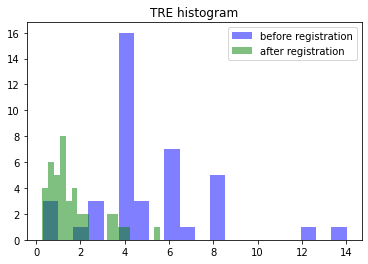

In [7]:
# Define a simple callback which allows us to monitor the Demons filter's progress.
def iteration_callback(filter):
    print(f"\r{filter.GetElapsedIterations()}: {filter.GetMetric():.2f}", end="")


fixed_image_index = 0
moving_image_index = 7

# Select a Demons filter and configure it.
demons_filter = sitk.FastSymmetricForcesDemonsRegistrationFilter()
demons_filter.SetNumberOfIterations(20)
# Regularization (update field - viscous, total field - elastic).
demons_filter.SetSmoothDisplacementField(True)
demons_filter.SetStandardDeviations(2.0)

# Add our simple callback to the registration filter.
demons_filter.AddCommand(
    sitk.sitkIterationEvent, lambda: iteration_callback(demons_filter)
)

# Run the registration.
tx = multiscale_demons(
    registration_algorithm=demons_filter,
    fixed_image=images[fixed_image_index],
    moving_image=images[moving_image_index],
    shrink_factors=[4, 2],
    smoothing_sigmas=[8, 4],
)

# Compare the initial and final TREs.
(
    initial_errors_mean,
    initial_errors_std,
    _,
    initial_errors_max,
    initial_errors,
) = ru.registration_errors(
    sitk.Euler3DTransform(), points[fixed_image_index], points[moving_image_index]
)
(
    final_errors_mean,
    final_errors_std,
    _,
    final_errors_max,
    final_errors,
) = ru.registration_errors(tx, points[fixed_image_index], points[moving_image_index])

plt.hist(initial_errors, bins=20, alpha=0.5, label="before registration", color="blue")
plt.hist(final_errors, bins=20, alpha=0.5, label="after registration", color="green")
plt.legend()
plt.title("TRE histogram")
print(
    f"\nInitial alignment errors in millimeters, mean(std): {initial_errors_mean:.2f}({initial_errors_std:.2f}), max: {initial_errors_max:.2f}"
)
print(
    f"Final alignment errors in millimeters, mean(std): {final_errors_mean:.2f}({final_errors_std:.2f}), max: {final_errors_max:.2f}"
)

## Transferring Segmentation

The following example illustrates the use of the Demons registration method to transfer a segmentation from one dataset to another. Note that we use the same multi scale demons framework we used above for registering 3D images to register 2D images.

Data provided courtesy of T. Sorensen, Signal Analysis and Interpretation Laboratory University of Southern California. Data acquisition protocol described in:

S.G. Lingala, A. Toutios, J. Toger, Y. Lim, Y. Zhu, Y-C. Kim, C. Vaz, S. Narayanan, K.S. Nayak "State of the art MRI protocol for comprehensive assessment of vocal tract structure and function" Proceedings of Interspeech, San Francisco, 2016.


**NOTE**: Segmented contour points are given in pixel coordinates. This is useful for plotting. To transfer the points to the second image we need to (1) use their physical coordinates, (2) transform them, and then (3) obtain the pixel coordinates for plotting. 

### Load Data

Fetching mr_slice_atlas/readme.txt


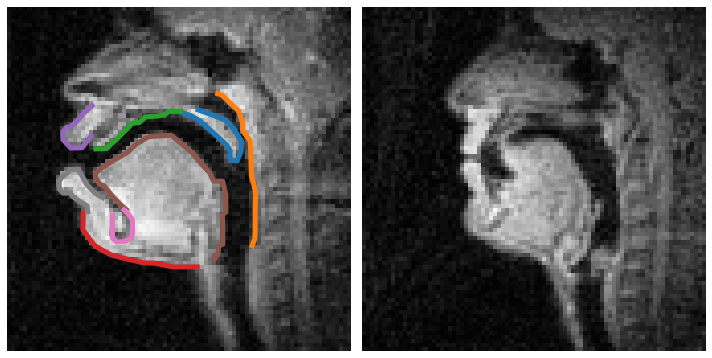

In [8]:
import glob
import pandas as pd
from gui import multi_image_display2D

# Fetch all of the data associated with this example.
data_directory = os.path.dirname(fdata("mr_slice_atlas/readme.txt"))

segmented_img = sitk.ReadImage(os.path.join(data_directory, "segmented_image.mha"))
new_img = sitk.ReadImage(os.path.join(data_directory, "new_image.mha"))

contours_list = []
for file_name in glob.glob(os.path.join(data_directory, "*.csv")):
    df = pd.read_csv(file_name)
    contours_list.append((list(df["X"]), list(df["Y"])))

# Display the images and overlay the contours onto the segmented image.
fig, axes = multi_image_display2D([segmented_img, new_img])
for contour in contours_list:
    axes[0].plot(contour[0], contour[1], linewidth=5)

### Register and transfer the segmentation.

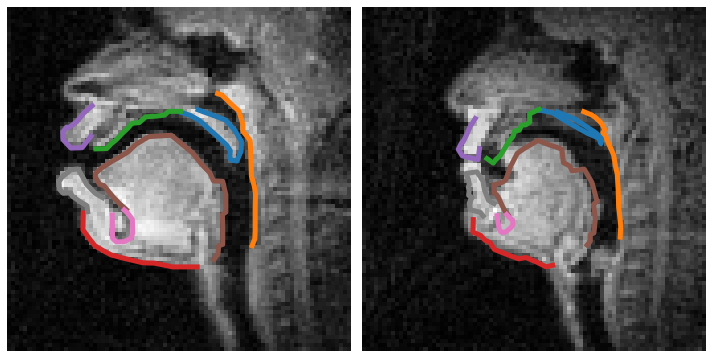

In [9]:
# Select a Demons filter and configure it.
demons_filter = sitk.DiffeomorphicDemonsRegistrationFilter()
demons_filter.SetNumberOfIterations(20)
# Regularization (update field - viscous, total field - elastic).
demons_filter.SetSmoothDisplacementField(True)
demons_filter.SetStandardDeviations(0.8)

# create initial transform
initial_tfm = initial_transform = sitk.CenteredTransformInitializer(
    segmented_img,
    new_img,
    sitk.Euler2DTransform(),
    sitk.CenteredTransformInitializerFilter.GEOMETRY,
)
# Run the registration.
final_tfm = multiscale_demons(
    registration_algorithm=demons_filter,
    fixed_image=segmented_img,
    moving_image=new_img,
    initial_transform=initial_tfm,
    shrink_factors=[6, 4, 2],
    smoothing_sigmas=[6, 4, 2],
)

# Display the transformed segmentation.
fig, axes = multi_image_display2D([segmented_img, new_img])
for contour in contours_list:
    # Plot on segmented image.
    axes[0].plot(contour[0], contour[1], linewidth=5)
    # Transform the contour points from segmented image to new image (requires the use of points in physical space)
    transformed_contour = [
        new_img.TransformPhysicalPointToContinuousIndex(
            final_tfm.TransformPoint(
                segmented_img.TransformContinuousIndexToPhysicalPoint(p)
            )
        )
        for p in zip(contour[0], contour[1])
    ]
    x_coords, y_coords = zip(*transformed_contour)
    axes[1].plot(x_coords, y_coords, linewidth=5)